In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from datetime import timedelta

import tqdm
from enflows.distributions import StandardNormal, MOG, Uniform
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform, ConditionalSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConstrainedAnglesSigmoid, ClampedAngles, LearnableManifoldFlow

In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

def uniform_p_norm (beta):
    return torch.ones_like(beta)

In [7]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    eps = 1e-5
    assert arr.shape[-1] >= 2
    radius = torch.linalg.norm(arr, dim=-1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(-1,)), dim=-1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum + eps), dims=(-1,))[...,:-1]
    angles = torch.acos(arr[..., :-1] / (sqrt_sums + eps))
    last_angle = ((arr[...,-1] >= 0).float() * angles[..., -1] + \
                (arr[...,-1] < 0).float() * (2 * np.pi - angles[..., -1]))

    return torch.cat((radius.unsqueeze(-1), angles[..., :-1], last_angle.unsqueeze(-1)), dim=-1)


In [8]:
def log_prior_angles (beta:torch.Tensor, sigma:torch.Tensor):
    beta_spherical = cartesian_to_spherical_torch(beta)[...,1:]
    exp = []
    angles = [0.5 * np.pi]
    #angles = [0., 0.5*np.pi, 1.*np.pi, 1.5*np.pi, 2*np.pi]
    for mean in angles:
        #exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        #print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
        exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
    angles = [1.5 * np.pi]
    #angles = [0., 0.5*np.pi, 1.*np.pi, 1.5*np.pi, 2*np.pi]
    for mean in angles:
        #exp.append(normal_exp(beta_spherical[...,:-1], mean, sigma))
        #print("shape exp", normal_exp(beta_spherical[...,:-1], mean, sigma).shape)
        exp.append(normal_exp(beta_spherical[...,-1:], mean, sigma))
        print("shape exp", normal_exp(beta_spherical[...,-1:], mean, sigma).shape)
    exp_torch = torch.cat(exp, dim=-1)
    # print("shape beta", beta_spherical.shape)
    # print("shape exp_torch", exp_torch.shape)
    # print("shape log_sum_exp", torch.logsumexp(exp_torch, dim=-1).shape)
    
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical[...,:-1].shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles) * beta_spherical.shape[-1])
    # const = torch.tensor(2*np.pi * sigma * len(angles))
    n_dim = beta_spherical[...,:-1].shape[-1]
    const = torch.tensor(2*np.pi * (sigma**2))
    return torch.logsumexp(exp_torch, dim=-1) - 0.5 * n_dim * torch.log(const) - torch.log(torch.tensor(len(angles)))
                   
    # theta_00_pi = torch.logsumexp( - 0.5 * (beta_spherical[...,:-1] / sigma ).square(), dim=-1) 
    # theta_05_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 0.5*np.pi) / sigma).square(), dim=-1) 
    # theta_10_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,:-1] - 1.0*np.pi) / sigma).square(), dim=-1)
    # 
    # #theta_15_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 1.5*np.pi) / (sigma + eps)).square(), dim=-1)
    # #theta_20_pi = torch.logsumexp( - 0.5 * ((beta_spherical[...,-1:] - 2.0*np.pi) / (sigma + eps)).square(), dim=-1)
    # 
    # prior_theta = theta_00_pi + theta_05_pi + theta_10_pi #+ theta_15_pi + theta_20_pi

    # return prior_theta

# def normal_exp (arr, mean, sigma):
#     return - 0.5 * ((arr - mean) / sigma ).square()
    
def normal_exp (arr, mean, sigma):
    return - 0.5 * ((arr - mean) / sigma ).square().sum(-1).unsqueeze(-1)

In [73]:
def build_flow_manifold (flow_dim, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    
    # means =  torch.tensor([[1.],[-1]]).repeat(1,flow_dim-1).to(device)
    # stds = (torch.ones(means.shape[0],flow_dim-1) * 0.3).to(device)
    # base_dist = MOG(means=means, stds=stds)
    
    # low = torch.tensor(-5.).to(device)
    # high = torch.tensor(5.).to(device)
    # base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )

        #transformation_layers.append(
        #InverseTransform(
        #        Sigmoid()
        #    )
        #)
        
        transformation_layers.append(
          InverseTransform(
              ActNorm(features=flow_dim-1)
          )
        )



    # transformation_layers.append(
    #    InverseTransform(
    #            CompositeTransform([
    #                ScalarScale(scale=2, trainable=False)])#,
    #                #ScalarShift(shift=-1, trainable=False)])
    #        )
    # )

    #transformation_layers.append(
    #   InverseTransform(
    #       Sigmoid()
    #   )
    #)

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=True)
            )
    )
    
    # transformation_layers.append(
    #     InverseTransform(
    #         ClampedAngles(eps=1e-5)
    #     )
    # )
    
    transformation_layers.append(
        InverseTransform(
            LearnableManifoldFlow(n = flow_dim-1)
        )
    )
    
    
    
    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    #low = torch.tensor(-1.).to(device)
    #high = torch.tensor(1.).to(device)
    #base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):

        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [48]:
def train_model (model, data, epochs=2_001, lr=1e-3, context=None, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            data_base = model.transform_to_noise(data, context)
            log_prob = model._distribution.log_prob(data_base, context)
            data_manifold, logabsdet = model._transform.inverse(data_base, context)
            log_prob = log_prob - logabsdet
            
            # q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(data_base)): breakpoint()
            if torch.any(torch.isnan(data_manifold)): breakpoint()
            
            # log_lik = uniform_p_norm(beta=q_log_prob_beta)
            # kl_div = torch.mean(q_log_prob_beta - log_lik)
            # kl_div.backward()

            #assert not torch.any(torch.isnan(q_log_prob))

            # log_prior = log_prior_angles(q_samples, torch.tensor(0.5))
            # assert not torch.any(torch.isnan(log_prior))
            log_likelihood = -torch.mean(log_prob)
            mse_loss = 5 * torch.norm(data_manifold - data, dim=1).mean()
            #kl_div = torch.mean(q_log_prob)
            total_loss = log_likelihood + mse_loss
            total_loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            #loss.append(torch.mean(q_log_prob).cpu().detach().numpy())
            log_lik_ = log_likelihood.cpu().detach().numpy()
            mse_ = mse_loss.cpu().detach().numpy()
            loss_ = total_loss.cpu().detach().numpy()
            loss.append([loss_, log_lik_, mse_])
            
            print(f"Training loss at step {epoch}: {loss_:.4f}")
            print(f"negative log-likelihood: {log_lik_:.4f} \t MSE: {mse_:.4f}")
            if epoch%100 == 0:
                samples_cart, _ = flow.sample_and_log_prob(num_samples=1000)
                samples_cart_np = samples_cart.detach().cpu().numpy()
                fig = plt.figure(figsize=(10,10))
                ax = fig.add_subplot(projection='3d')
                ax.scatter(samples_cart_np[:,0], samples_cart_np[:,1], samples_cart_np[:,2], marker=".")
                ax.set_xlabel('X Label')
                ax.set_ylabel('Y Label')
                ax.set_zlabel('Z Label')
                plt.show()

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, np.array(loss)

In [149]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

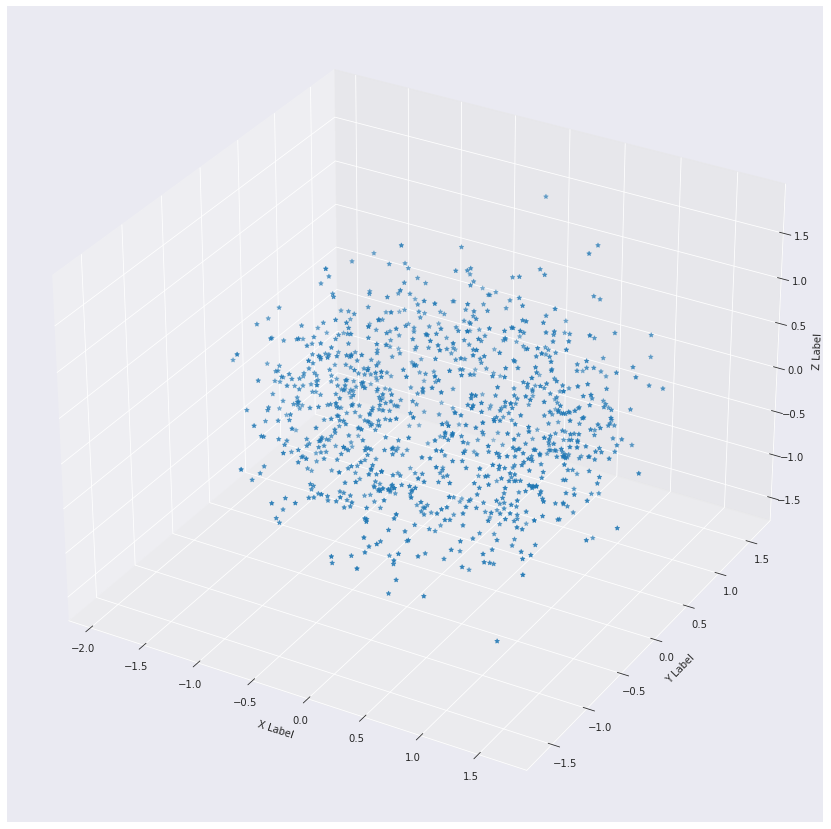

In [37]:
def generate_spherical_with_noise (n, d, r, std, device="cuda"):
    phi = torch.rand(n, 1) * 2 * np.pi
    radius = torch.ones(n,1) * r
    if d == 1:
        angles = torch.cat((radius, phi), dim=1)
    elif d>1:
        theta = torch.rand(n, d-2) * np.pi
        angles = torch.cat((radius, theta, phi), dim=1)
    else:
        raise ValueError("d must be strictly greater than 1")
    
    x = spherical_to_cartesian_torch(angles)
    noise = torch.normal(torch.zeros_like(x), torch.ones_like(x)*std)

    return (x + noise).to(device)

data = generate_spherical_with_noise(n=1000, d=3, r=1, std=0.3)
data_np = data.detach().cpu().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_np[:,0], data_np[:,1], data_np[:,2], marker="*")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [26]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [75]:
device = 'cuda'
set_random_seeds(123)

# Build Model
flow_dim = 3
flow = build_flow_manifold(flow_dim, n_layers=3, hidden_features=256, device=device)
#flow = build_flow_lipshitz_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

params = dict(lr=1e-3,
              epochs=2000,
              sample_size=1_000,
              device=device)

In [139]:
#torch.autograd.set_detect_anomaly(False)

In [19]:
samples_cart, log_probs = flow.sample_and_log_prob(num_samples=10)
samples_sph, logabsdet_sph = flow._transform(samples_cart)
samples_cart_, logabsdet_cart = flow._transform.inverse(samples_sph)
samples_cart_, samples_cart

(tensor([[-0.3474, -0.2948, -0.3208],
         [ 0.5764, -0.4494, -0.1238],
         [ 0.3443, -0.3452, -0.4202],
         [-0.3500, -0.1953, -0.3463],
         [-0.3508, -0.4417, -0.2142],
         [ 0.3502, -0.4812, -0.3197],
         [ 0.4433, -0.0735, -0.4078],
         [-0.4513, -0.1007,  0.6538],
         [ 0.5159,  0.7284,  0.4239],
         [-0.4808, -0.4441,  0.1786]], device='cuda:0', grad_fn=<CatBackward0>),
 tensor([[-0.3474, -0.2948, -0.3208],
         [ 0.5764, -0.4494, -0.1238],
         [ 0.3443, -0.3452, -0.4202],
         [-0.3501, -0.1953, -0.3463],
         [-0.3508, -0.4418, -0.2142],
         [ 0.3502, -0.4812, -0.3196],
         [ 0.4433, -0.0735, -0.4078],
         [-0.4513, -0.1007,  0.6538],
         [ 0.5159,  0.7284,  0.4239],
         [-0.4808, -0.4441,  0.1785]], device='cuda:0', grad_fn=<CatBackward0>))

In [20]:
samples_cart, log_probs = flow.sample_and_log_prob(num_samples=10)
samples_sph, logabsdet_sph = flow._transform(samples_cart)
log_prob = flow._distribution.log_prob(samples_sph, context=None)
data_manifold, logabsdet = flow._transform.inverse(samples_sph, context=None)
log_prob = log_prob - logabsdet
log_probs, log_prob

(tensor([-1.7716, -0.6578, -0.7198, -1.2317, -1.5045, -2.2678, -0.3588, -0.3206,
         -1.4870, -3.4581], device='cuda:0', grad_fn=<SubBackward0>),
 tensor([-1.7716, -0.6580, -0.7199, -1.2314, -1.5046, -2.2678, -0.3589, -0.3212,
         -1.4870, -3.4581], device='cuda:0', grad_fn=<SubBackward0>))

Training loss at step 0: 7.4575
negative log-likelihood: 4.4325 	 MSE: 3.0250


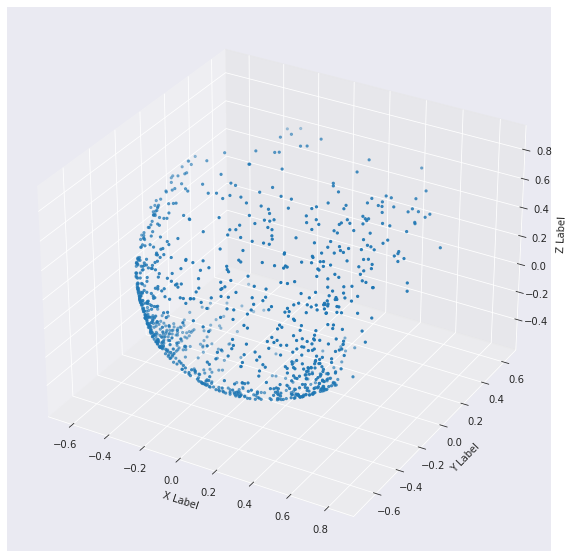

Training loss at step 1: 8.7129
negative log-likelihood: 6.4387 	 MSE: 2.2743
Training loss at step 2: 6.9664
negative log-likelihood: 4.6922 	 MSE: 2.2742
Training loss at step 3: 6.4140
negative log-likelihood: 4.1626 	 MSE: 2.2513
Training loss at step 4: 6.3221
negative log-likelihood: 4.1051 	 MSE: 2.2171
Training loss at step 5: 6.2838
negative log-likelihood: 4.1079 	 MSE: 2.1759
Training loss at step 6: 6.2759
negative log-likelihood: 4.1459 	 MSE: 2.1300
Training loss at step 7: 6.1455
negative log-likelihood: 4.0647 	 MSE: 2.0808
Training loss at step 8: 6.0857
negative log-likelihood: 4.0562 	 MSE: 2.0295
Training loss at step 9: 5.9784
negative log-likelihood: 4.0015 	 MSE: 1.9769
Training loss at step 10: 6.0105
negative log-likelihood: 4.0871 	 MSE: 1.9233
Training loss at step 11: 5.9213
negative log-likelihood: 4.0523 	 MSE: 1.8689
Training loss at step 12: 5.8459
negative log-likelihood: 4.0318 	 MSE: 1.8141
Training loss at step 13: 5.7650
negative log-likelihood: 4.0

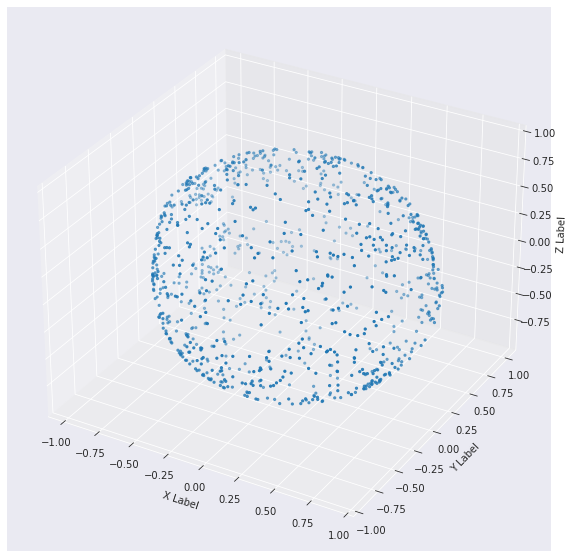

Training loss at step 101: 4.1632
negative log-likelihood: 2.7527 	 MSE: 1.4105
Training loss at step 102: 4.1589
negative log-likelihood: 2.7488 	 MSE: 1.4101
Training loss at step 103: 4.1595
negative log-likelihood: 2.7498 	 MSE: 1.4097
Training loss at step 104: 4.1438
negative log-likelihood: 2.7345 	 MSE: 1.4093
Training loss at step 105: 4.1426
negative log-likelihood: 2.7337 	 MSE: 1.4089
Training loss at step 106: 4.1245
negative log-likelihood: 2.7159 	 MSE: 1.4087
Training loss at step 107: 4.1311
negative log-likelihood: 2.7225 	 MSE: 1.4086
Training loss at step 108: 4.1218
negative log-likelihood: 2.7131 	 MSE: 1.4087
Training loss at step 109: 4.1146
negative log-likelihood: 2.7058 	 MSE: 1.4088
Training loss at step 110: 4.1090
negative log-likelihood: 2.7001 	 MSE: 1.4089
Training loss at step 111: 4.1010
negative log-likelihood: 2.6919 	 MSE: 1.4092
Training loss at step 112: 4.0991
negative log-likelihood: 2.6896 	 MSE: 1.4095
Training loss at step 113: 4.0962
negati

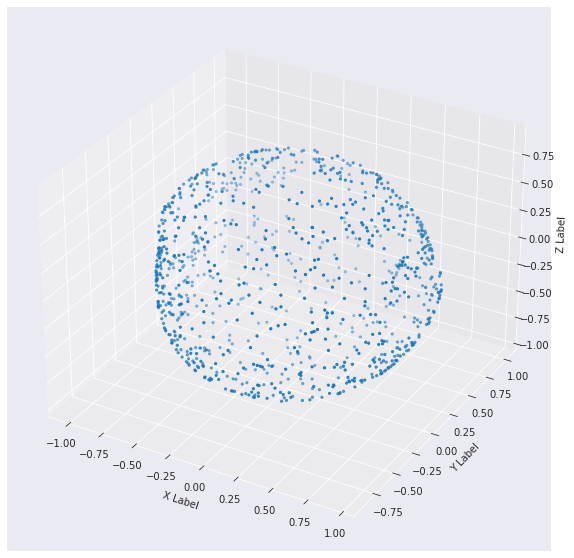

Training loss at step 201: 3.7936
negative log-likelihood: 2.3964 	 MSE: 1.3972
Training loss at step 202: 3.7994
negative log-likelihood: 2.4017 	 MSE: 1.3977
Training loss at step 203: 3.7854
negative log-likelihood: 2.3884 	 MSE: 1.3970
Training loss at step 204: 3.7967
negative log-likelihood: 2.4002 	 MSE: 1.3965
Training loss at step 205: 3.7829
negative log-likelihood: 2.3868 	 MSE: 1.3961
Training loss at step 206: 3.7907
negative log-likelihood: 2.3945 	 MSE: 1.3963
Training loss at step 207: 3.7918
negative log-likelihood: 2.3947 	 MSE: 1.3972
Training loss at step 208: 3.7821
negative log-likelihood: 2.3840 	 MSE: 1.3981
Training loss at step 209: 3.7792
negative log-likelihood: 2.3815 	 MSE: 1.3977
Training loss at step 210: 3.7780
negative log-likelihood: 2.3808 	 MSE: 1.3972
Training loss at step 211: 3.7716
negative log-likelihood: 2.3744 	 MSE: 1.3972
Training loss at step 212: 3.7704
negative log-likelihood: 2.3727 	 MSE: 1.3976
Training loss at step 213: 3.7656
negati

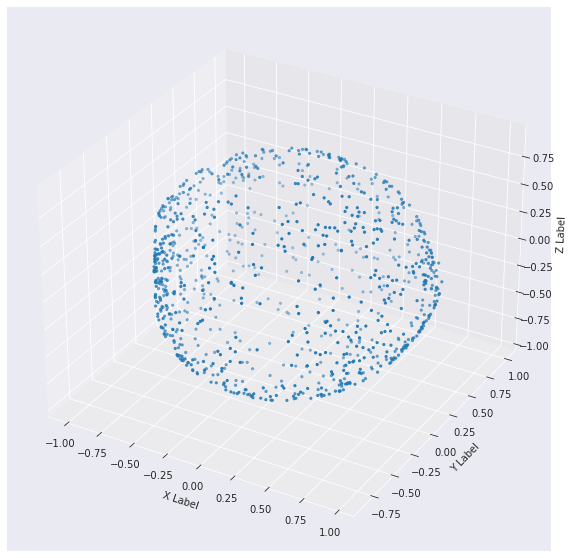

Training loss at step 301: 3.6746
negative log-likelihood: 2.2904 	 MSE: 1.3842
Training loss at step 302: 3.6763
negative log-likelihood: 2.2926 	 MSE: 1.3837
Training loss at step 303: 3.6718
negative log-likelihood: 2.2879 	 MSE: 1.3839
Training loss at step 304: 3.6744
negative log-likelihood: 2.2903 	 MSE: 1.3841
Training loss at step 305: 3.6713
negative log-likelihood: 2.2872 	 MSE: 1.3841
Training loss at step 306: 3.6711
negative log-likelihood: 2.2876 	 MSE: 1.3835
Training loss at step 307: 3.6691
negative log-likelihood: 2.2863 	 MSE: 1.3828
Training loss at step 308: 3.6713
negative log-likelihood: 2.2890 	 MSE: 1.3823
Training loss at step 309: 3.6655
negative log-likelihood: 2.2835 	 MSE: 1.3820
Training loss at step 310: 3.6663
negative log-likelihood: 2.2846 	 MSE: 1.3818
Training loss at step 311: 3.6636
negative log-likelihood: 2.2819 	 MSE: 1.3817
Training loss at step 312: 3.6616
negative log-likelihood: 2.2800 	 MSE: 1.3816
Training loss at step 313: 3.6668
negati

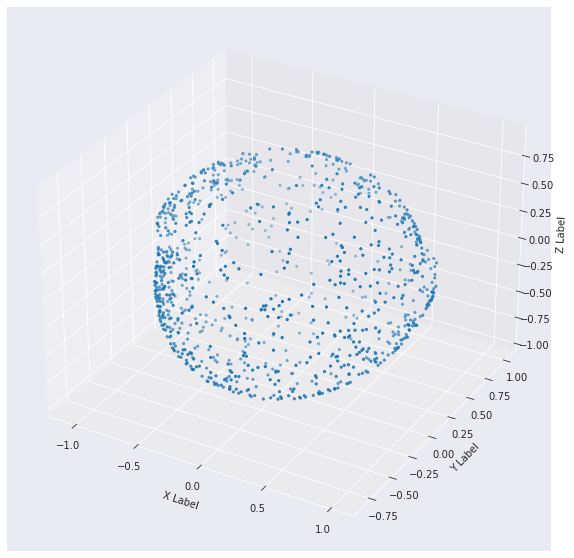

Training loss at step 401: 3.6296
negative log-likelihood: 2.2599 	 MSE: 1.3698
Training loss at step 402: 3.6268
negative log-likelihood: 2.2561 	 MSE: 1.3707
Training loss at step 403: 3.6269
negative log-likelihood: 2.2564 	 MSE: 1.3705
Training loss at step 404: 3.6294
negative log-likelihood: 2.2596 	 MSE: 1.3698
Training loss at step 405: 3.6282
negative log-likelihood: 2.2580 	 MSE: 1.3702
Training loss at step 406: 3.6330
negative log-likelihood: 2.2643 	 MSE: 1.3687
Training loss at step 407: 3.6317
negative log-likelihood: 2.2624 	 MSE: 1.3693
Training loss at step 408: 3.6299
negative log-likelihood: 2.2602 	 MSE: 1.3697
Training loss at step 409: 3.6279
negative log-likelihood: 2.2581 	 MSE: 1.3698
Training loss at step 410: 3.6290
negative log-likelihood: 2.2589 	 MSE: 1.3701
Training loss at step 411: 3.6297
negative log-likelihood: 2.2599 	 MSE: 1.3699
Training loss at step 412: 3.6367
negative log-likelihood: 2.2666 	 MSE: 1.3701
Training loss at step 413: 3.6293
negati

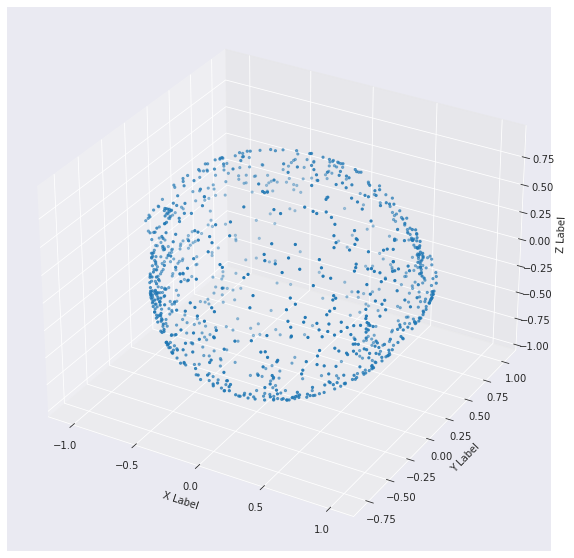

Training loss at step 501: 3.6145
negative log-likelihood: 2.2480 	 MSE: 1.3665
Training loss at step 502: 3.6244
negative log-likelihood: 2.2552 	 MSE: 1.3692
Training loss at step 503: 3.6143
negative log-likelihood: 2.2427 	 MSE: 1.3716
Training loss at step 504: 3.6201
negative log-likelihood: 2.2513 	 MSE: 1.3688
Training loss at step 505: 3.6157
negative log-likelihood: 2.2484 	 MSE: 1.3673
Training loss at step 506: 3.6156
negative log-likelihood: 2.2481 	 MSE: 1.3674
Training loss at step 507: 3.6178
negative log-likelihood: 2.2482 	 MSE: 1.3696
Training loss at step 508: 3.6160
negative log-likelihood: 2.2449 	 MSE: 1.3710
Training loss at step 509: 3.6157
negative log-likelihood: 2.2476 	 MSE: 1.3681
Training loss at step 510: 3.6131
negative log-likelihood: 2.2473 	 MSE: 1.3659
Training loss at step 511: 3.6200
negative log-likelihood: 2.2518 	 MSE: 1.3683
Training loss at step 512: 3.6196
negative log-likelihood: 2.2488 	 MSE: 1.3708
Training loss at step 513: 3.6219
negati

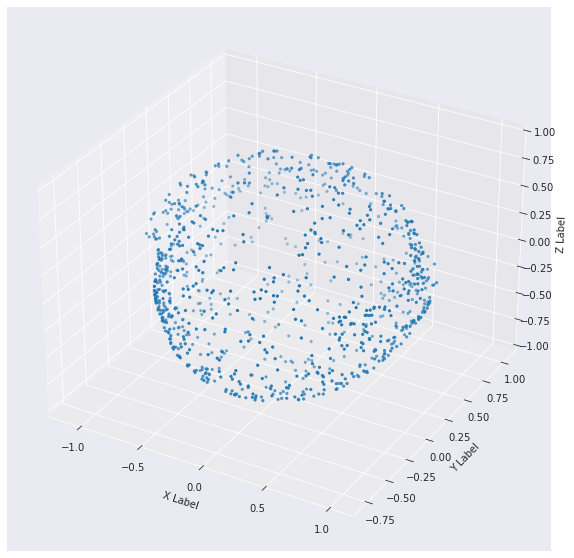

Training loss at step 601: 3.5869
negative log-likelihood: 2.2228 	 MSE: 1.3641
Training loss at step 602: 3.5842
negative log-likelihood: 2.2207 	 MSE: 1.3635
Training loss at step 603: 3.5850
negative log-likelihood: 2.2211 	 MSE: 1.3639
Training loss at step 604: 3.5820
negative log-likelihood: 2.2176 	 MSE: 1.3645
Training loss at step 605: 3.5834
negative log-likelihood: 2.2199 	 MSE: 1.3636
Training loss at step 606: 3.5822
negative log-likelihood: 2.2195 	 MSE: 1.3627
Training loss at step 607: 3.5845
negative log-likelihood: 2.2217 	 MSE: 1.3628
Training loss at step 608: 3.5817
negative log-likelihood: 2.2187 	 MSE: 1.3630
Training loss at step 609: 3.5809
negative log-likelihood: 2.2185 	 MSE: 1.3624
Training loss at step 610: 3.5845
negative log-likelihood: 2.2216 	 MSE: 1.3629
Training loss at step 611: 3.5868
negative log-likelihood: 2.2245 	 MSE: 1.3623
Training loss at step 612: 3.5874
negative log-likelihood: 2.2249 	 MSE: 1.3625
Training loss at step 613: 3.5842
negati

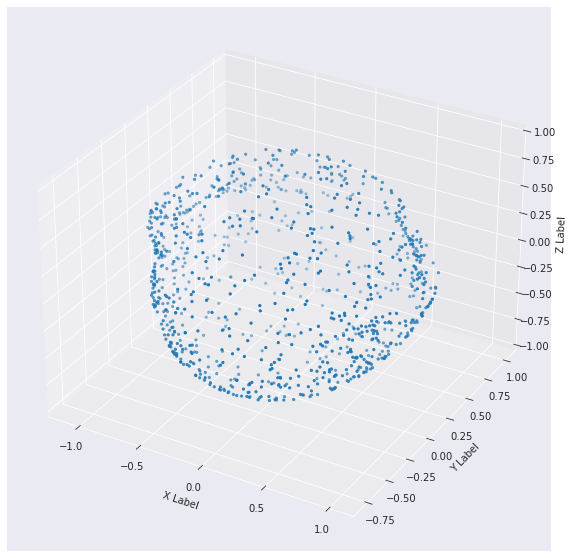

Training loss at step 701: 3.5911
negative log-likelihood: 2.2371 	 MSE: 1.3541
Training loss at step 702: 3.5956
negative log-likelihood: 2.2422 	 MSE: 1.3535
Training loss at step 703: 3.5952
negative log-likelihood: 2.2417 	 MSE: 1.3535
Training loss at step 704: 3.5990
negative log-likelihood: 2.2455 	 MSE: 1.3535
Training loss at step 705: 3.5998
negative log-likelihood: 2.2471 	 MSE: 1.3526
Training loss at step 706: 3.5957
negative log-likelihood: 2.2426 	 MSE: 1.3531
Training loss at step 707: 3.6039
negative log-likelihood: 2.2509 	 MSE: 1.3530
Training loss at step 708: 3.6071
negative log-likelihood: 2.2549 	 MSE: 1.3521
Training loss at step 709: 3.5970
negative log-likelihood: 2.2450 	 MSE: 1.3520
Training loss at step 710: 3.6047
negative log-likelihood: 2.2528 	 MSE: 1.3519
Training loss at step 711: 3.5983
negative log-likelihood: 2.2463 	 MSE: 1.3520
Training loss at step 712: 3.5975
negative log-likelihood: 2.2456 	 MSE: 1.3518
Training loss at step 713: 3.5954
negati

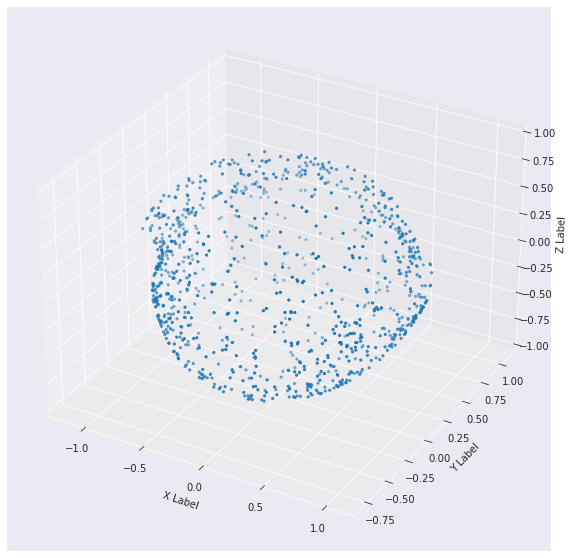

Training loss at step 801: 3.5875
negative log-likelihood: 2.2464 	 MSE: 1.3410
Training loss at step 802: 3.6028
negative log-likelihood: 2.2613 	 MSE: 1.3415
Training loss at step 803: 3.6087
negative log-likelihood: 2.2673 	 MSE: 1.3414
Training loss at step 804: 3.6045
negative log-likelihood: 2.2637 	 MSE: 1.3408
Training loss at step 805: 3.5961
negative log-likelihood: 2.2539 	 MSE: 1.3423
Training loss at step 806: 3.6025
negative log-likelihood: 2.2605 	 MSE: 1.3420
Training loss at step 807: 3.5981
negative log-likelihood: 2.2583 	 MSE: 1.3398
Training loss at step 808: 3.5944
negative log-likelihood: 2.2562 	 MSE: 1.3382
Training loss at step 809: 3.5983
negative log-likelihood: 2.2592 	 MSE: 1.3391
Training loss at step 810: 3.5968
negative log-likelihood: 2.2568 	 MSE: 1.3401
Training loss at step 811: 3.5921
negative log-likelihood: 2.2511 	 MSE: 1.3410
Training loss at step 812: 3.5890
negative log-likelihood: 2.2476 	 MSE: 1.3415
Training loss at step 813: 3.5981
negati

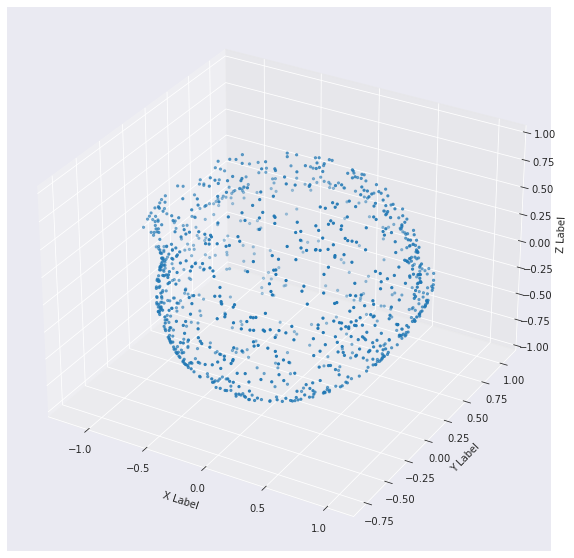

Training loss at step 901: 3.6098
negative log-likelihood: 2.2690 	 MSE: 1.3408
Training loss at step 902: 3.6064
negative log-likelihood: 2.2659 	 MSE: 1.3404
Training loss at step 903: 3.5989
negative log-likelihood: 2.2596 	 MSE: 1.3393
Training loss at step 904: 3.6057
negative log-likelihood: 2.2686 	 MSE: 1.3371
Training loss at step 905: 3.6033
negative log-likelihood: 2.2643 	 MSE: 1.3390
Training loss at step 906: 3.6033
negative log-likelihood: 2.2634 	 MSE: 1.3400
Training loss at step 907: 3.5994
negative log-likelihood: 2.2597 	 MSE: 1.3396
Training loss at step 908: 3.5985
negative log-likelihood: 2.2585 	 MSE: 1.3400
Training loss at step 909: 3.5953
negative log-likelihood: 2.2544 	 MSE: 1.3410
Training loss at step 910: 3.5941
negative log-likelihood: 2.2495 	 MSE: 1.3445
Training loss at step 911: 3.6047
negative log-likelihood: 2.2609 	 MSE: 1.3438
Training loss at step 912: 3.5954
negative log-likelihood: 2.2547 	 MSE: 1.3407
Training loss at step 913: 3.5986
negati

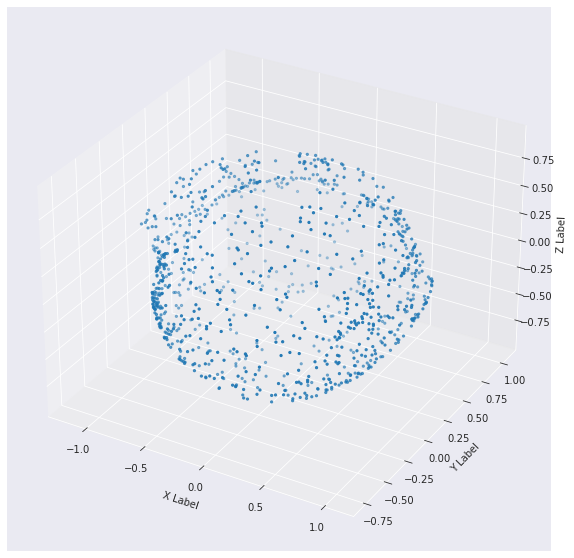

Training loss at step 1001: 3.5871
negative log-likelihood: 2.2474 	 MSE: 1.3397
Training loss at step 1002: 3.5847
negative log-likelihood: 2.2469 	 MSE: 1.3378
Training loss at step 1003: 3.5806
negative log-likelihood: 2.2424 	 MSE: 1.3382
Training loss at step 1004: 3.5867
negative log-likelihood: 2.2466 	 MSE: 1.3401
Training loss at step 1005: 3.5860
negative log-likelihood: 2.2478 	 MSE: 1.3382
Training loss at step 1006: 3.5862
negative log-likelihood: 2.2523 	 MSE: 1.3340
Training loss at step 1007: 3.5830
negative log-likelihood: 2.2487 	 MSE: 1.3343
Training loss at step 1008: 3.5836
negative log-likelihood: 2.2446 	 MSE: 1.3390
Training loss at step 1009: 3.5786
negative log-likelihood: 2.2352 	 MSE: 1.3435
Training loss at step 1010: 3.5761
negative log-likelihood: 2.2368 	 MSE: 1.3393
Training loss at step 1011: 3.5768
negative log-likelihood: 2.2420 	 MSE: 1.3348
Training loss at step 1012: 3.5799
negative log-likelihood: 2.2455 	 MSE: 1.3344
Training loss at step 1013: 

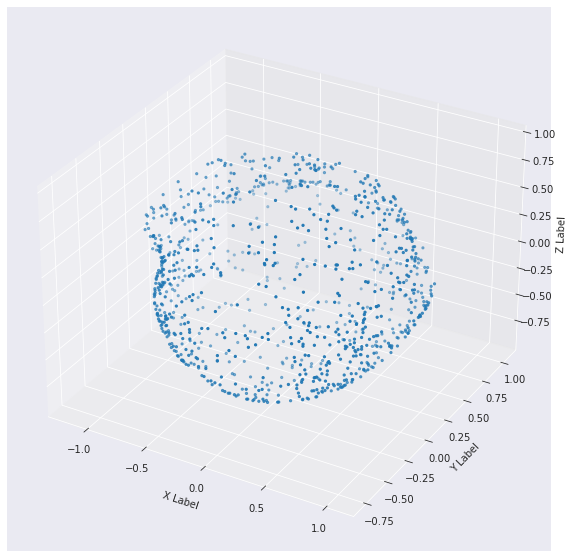

Training loss at step 1101: 3.5930
negative log-likelihood: 2.2559 	 MSE: 1.3371
Training loss at step 1102: 3.5861
negative log-likelihood: 2.2471 	 MSE: 1.3390
Training loss at step 1103: 3.5824
negative log-likelihood: 2.2431 	 MSE: 1.3393
Training loss at step 1104: 3.5887
negative log-likelihood: 2.2507 	 MSE: 1.3380
Training loss at step 1105: 3.5784
negative log-likelihood: 2.2424 	 MSE: 1.3360
Training loss at step 1106: 3.5821
negative log-likelihood: 2.2432 	 MSE: 1.3389
Training loss at step 1107: 3.5722
negative log-likelihood: 2.2319 	 MSE: 1.3403
Training loss at step 1108: 3.5788
negative log-likelihood: 2.2411 	 MSE: 1.3377
Training loss at step 1109: 3.5779
negative log-likelihood: 2.2416 	 MSE: 1.3363
Training loss at step 1110: 3.5872
negative log-likelihood: 2.2486 	 MSE: 1.3386
Training loss at step 1111: 3.5749
negative log-likelihood: 2.2372 	 MSE: 1.3378
Training loss at step 1112: 3.5914
negative log-likelihood: 2.2533 	 MSE: 1.3381
Training loss at step 1113: 

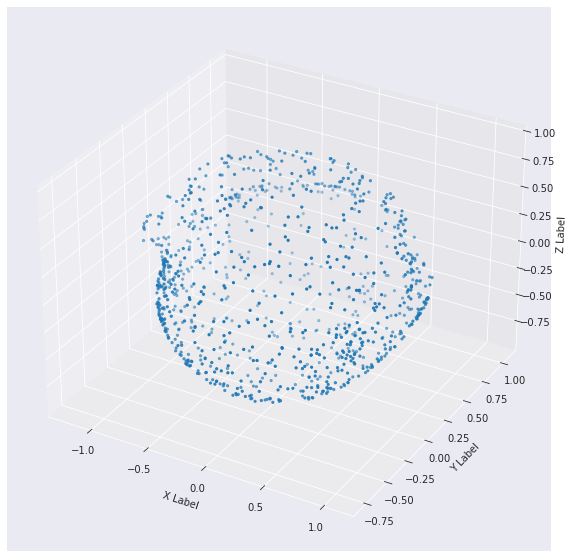

Training loss at step 1201: 3.5795
negative log-likelihood: 2.2463 	 MSE: 1.3332
Training loss at step 1202: 3.5684
negative log-likelihood: 2.2259 	 MSE: 1.3424
Training loss at step 1203: 3.5800
negative log-likelihood: 2.2374 	 MSE: 1.3426
Training loss at step 1204: 3.5797
negative log-likelihood: 2.2448 	 MSE: 1.3349
Training loss at step 1205: 3.5773
negative log-likelihood: 2.2499 	 MSE: 1.3275
Training loss at step 1206: 3.5747
negative log-likelihood: 2.2467 	 MSE: 1.3280
Training loss at step 1207: 3.5690
negative log-likelihood: 2.2340 	 MSE: 1.3350
Training loss at step 1208: 3.5680
negative log-likelihood: 2.2282 	 MSE: 1.3398
Training loss at step 1209: 3.5718
negative log-likelihood: 2.2345 	 MSE: 1.3373
Training loss at step 1210: 3.5701
negative log-likelihood: 2.2413 	 MSE: 1.3288
Training loss at step 1211: 3.5788
negative log-likelihood: 2.2514 	 MSE: 1.3274
Training loss at step 1212: 3.5719
negative log-likelihood: 2.2396 	 MSE: 1.3323
Training loss at step 1213: 

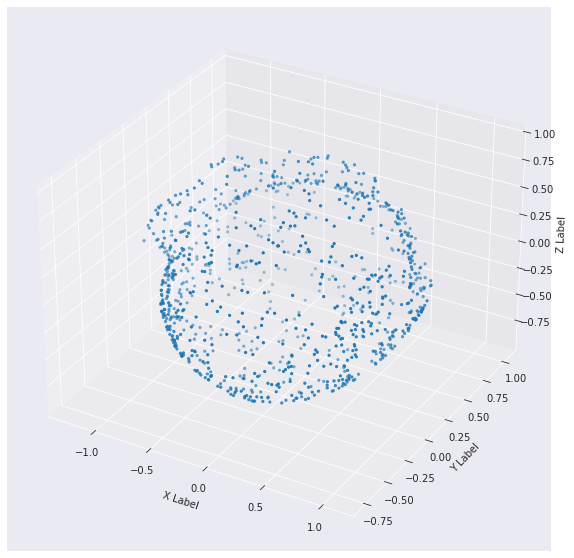

Training loss at step 1301: 3.5606
negative log-likelihood: 2.2300 	 MSE: 1.3306
Training loss at step 1302: 3.5671
negative log-likelihood: 2.2318 	 MSE: 1.3353
Training loss at step 1303: 3.5731
negative log-likelihood: 2.2372 	 MSE: 1.3359
Training loss at step 1304: 3.5793
negative log-likelihood: 2.2475 	 MSE: 1.3319
Training loss at step 1305: 3.5646
negative log-likelihood: 2.2329 	 MSE: 1.3317
Training loss at step 1306: 3.5930
negative log-likelihood: 2.2572 	 MSE: 1.3358
Training loss at step 1307: 3.5847
negative log-likelihood: 2.2518 	 MSE: 1.3329
Training loss at step 1308: 3.5814
negative log-likelihood: 2.2505 	 MSE: 1.3310
Training loss at step 1309: 3.5814
negative log-likelihood: 2.2458 	 MSE: 1.3356
Training loss at step 1310: 3.5791
negative log-likelihood: 2.2445 	 MSE: 1.3346
Training loss at step 1311: 3.5691
negative log-likelihood: 2.2365 	 MSE: 1.3326
Training loss at step 1312: 3.5742
negative log-likelihood: 2.2393 	 MSE: 1.3349
Training loss at step 1313: 

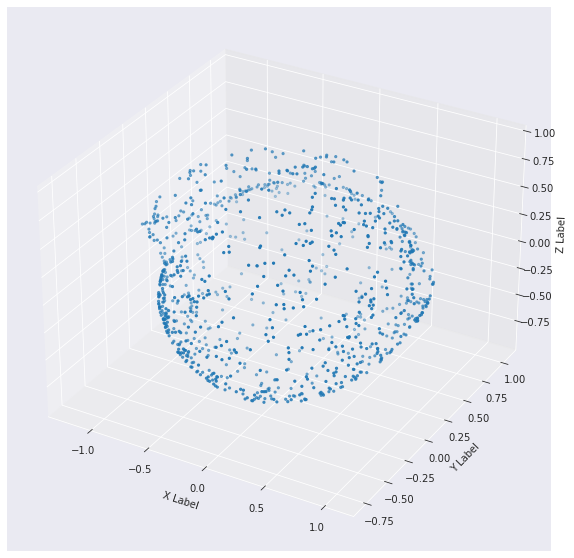

Training loss at step 1401: 3.5528
negative log-likelihood: 2.2217 	 MSE: 1.3311
Training loss at step 1402: 3.5486
negative log-likelihood: 2.2149 	 MSE: 1.3337
Training loss at step 1403: 3.5647
negative log-likelihood: 2.2300 	 MSE: 1.3347
Training loss at step 1404: 3.5511
negative log-likelihood: 2.2221 	 MSE: 1.3290
Training loss at step 1405: 3.5496
negative log-likelihood: 2.2192 	 MSE: 1.3304
Training loss at step 1406: 3.5637
negative log-likelihood: 2.2252 	 MSE: 1.3385
Training loss at step 1407: 3.5496
negative log-likelihood: 2.2115 	 MSE: 1.3382
Training loss at step 1408: 3.5538
negative log-likelihood: 2.2218 	 MSE: 1.3321
Training loss at step 1409: 3.5589
negative log-likelihood: 2.2307 	 MSE: 1.3282
Training loss at step 1410: 3.5580
negative log-likelihood: 2.2254 	 MSE: 1.3325
Training loss at step 1411: 3.5623
negative log-likelihood: 2.2265 	 MSE: 1.3358
Training loss at step 1412: 3.5599
negative log-likelihood: 2.2250 	 MSE: 1.3348
Training loss at step 1413: 

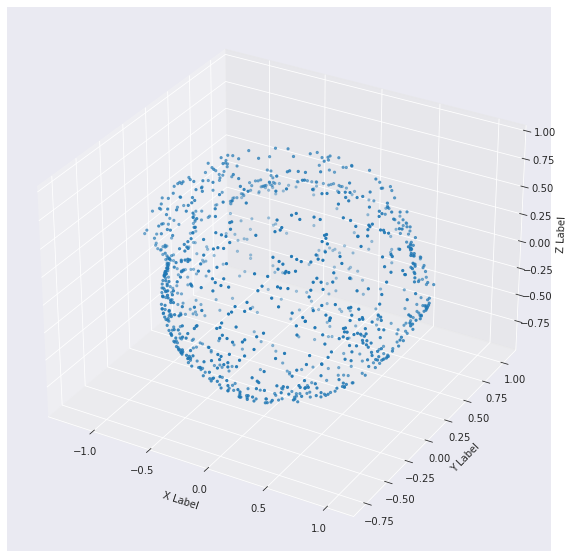

Training loss at step 1501: 3.5200
negative log-likelihood: 2.1844 	 MSE: 1.3356
Training loss at step 1502: 3.5229
negative log-likelihood: 2.1856 	 MSE: 1.3372
Training loss at step 1503: 3.5259
negative log-likelihood: 2.1922 	 MSE: 1.3338
Training loss at step 1504: 3.5280
negative log-likelihood: 2.1980 	 MSE: 1.3300
Training loss at step 1505: 3.5338
negative log-likelihood: 2.2032 	 MSE: 1.3306
Training loss at step 1506: 3.5309
negative log-likelihood: 2.1979 	 MSE: 1.3330
Training loss at step 1507: 3.5306
negative log-likelihood: 2.1943 	 MSE: 1.3363
Training loss at step 1508: 3.5400
negative log-likelihood: 2.2013 	 MSE: 1.3387
Training loss at step 1509: 3.5449
negative log-likelihood: 2.2098 	 MSE: 1.3352
Training loss at step 1510: 3.5383
negative log-likelihood: 2.2056 	 MSE: 1.3327
Training loss at step 1511: 3.5235
negative log-likelihood: 2.1926 	 MSE: 1.3309
Training loss at step 1512: 3.5197
negative log-likelihood: 2.1865 	 MSE: 1.3332
Training loss at step 1513: 

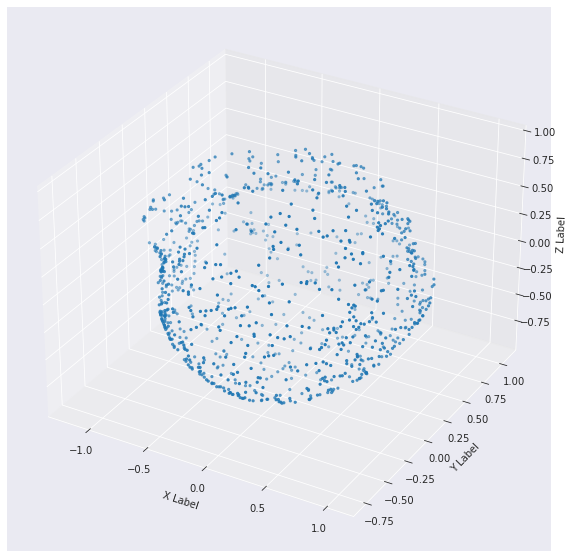

Training loss at step 1601: 3.5111
negative log-likelihood: 2.1804 	 MSE: 1.3307
Training loss at step 1602: 3.5203
negative log-likelihood: 2.1866 	 MSE: 1.3337
Training loss at step 1603: 3.5180
negative log-likelihood: 2.1852 	 MSE: 1.3327
Training loss at step 1604: 3.5225
negative log-likelihood: 2.1915 	 MSE: 1.3310
Training loss at step 1605: 3.5156
negative log-likelihood: 2.1820 	 MSE: 1.3336
Training loss at step 1606: 3.5190
negative log-likelihood: 2.1845 	 MSE: 1.3345
Training loss at step 1607: 3.5227
negative log-likelihood: 2.1929 	 MSE: 1.3299
Training loss at step 1608: 3.5247
negative log-likelihood: 2.1929 	 MSE: 1.3317
Training loss at step 1609: 3.5114
negative log-likelihood: 2.1745 	 MSE: 1.3370
Training loss at step 1610: 3.5138
negative log-likelihood: 2.1815 	 MSE: 1.3323
Training loss at step 1611: 3.5292
negative log-likelihood: 2.2002 	 MSE: 1.3290
Training loss at step 1612: 3.5200
negative log-likelihood: 2.1870 	 MSE: 1.3330
Training loss at step 1613: 

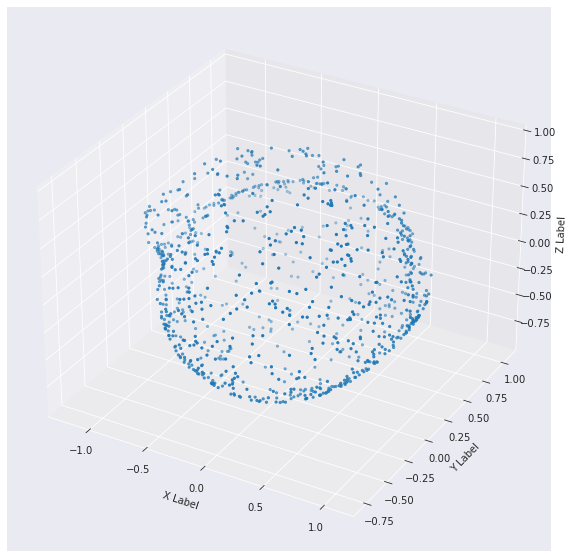

Training loss at step 1701: 3.5074
negative log-likelihood: 2.1744 	 MSE: 1.3330
Training loss at step 1702: 3.5035
negative log-likelihood: 2.1675 	 MSE: 1.3361
Training loss at step 1703: 3.5075
negative log-likelihood: 2.1718 	 MSE: 1.3357
Training loss at step 1704: 3.5029
negative log-likelihood: 2.1695 	 MSE: 1.3334
Training loss at step 1705: 3.4966
negative log-likelihood: 2.1646 	 MSE: 1.3320
Training loss at step 1706: 3.4919
negative log-likelihood: 2.1607 	 MSE: 1.3312
Training loss at step 1707: 3.5026
negative log-likelihood: 2.1705 	 MSE: 1.3322
Training loss at step 1708: 3.5046
negative log-likelihood: 2.1717 	 MSE: 1.3329
Training loss at step 1709: 3.5007
negative log-likelihood: 2.1684 	 MSE: 1.3323
Training loss at step 1710: 3.5023
negative log-likelihood: 2.1694 	 MSE: 1.3330
Training loss at step 1711: 3.5098
negative log-likelihood: 2.1775 	 MSE: 1.3323
Training loss at step 1712: 3.5131
negative log-likelihood: 2.1818 	 MSE: 1.3314
Training loss at step 1713: 

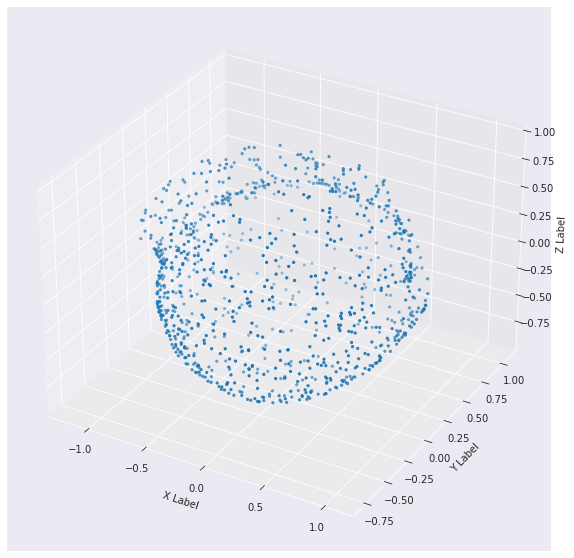

Training loss at step 1801: 3.5085
negative log-likelihood: 2.1735 	 MSE: 1.3351
Training loss at step 1802: 3.4941
negative log-likelihood: 2.1622 	 MSE: 1.3319
Training loss at step 1803: 3.4990
negative log-likelihood: 2.1688 	 MSE: 1.3302
Training loss at step 1804: 3.5085
negative log-likelihood: 2.1751 	 MSE: 1.3333
Training loss at step 1805: 3.4964
negative log-likelihood: 2.1594 	 MSE: 1.3369
Training loss at step 1806: 3.4859
negative log-likelihood: 2.1536 	 MSE: 1.3323
Training loss at step 1807: 3.4931
negative log-likelihood: 2.1651 	 MSE: 1.3280
Training loss at step 1808: 3.4955
negative log-likelihood: 2.1612 	 MSE: 1.3343
Training loss at step 1809: 3.4932
negative log-likelihood: 2.1591 	 MSE: 1.3341
Training loss at step 1810: 3.4939
negative log-likelihood: 2.1644 	 MSE: 1.3295
Training loss at step 1811: 3.4839
negative log-likelihood: 2.1508 	 MSE: 1.3330
Training loss at step 1812: 3.4860
negative log-likelihood: 2.1501 	 MSE: 1.3359
Training loss at step 1813: 

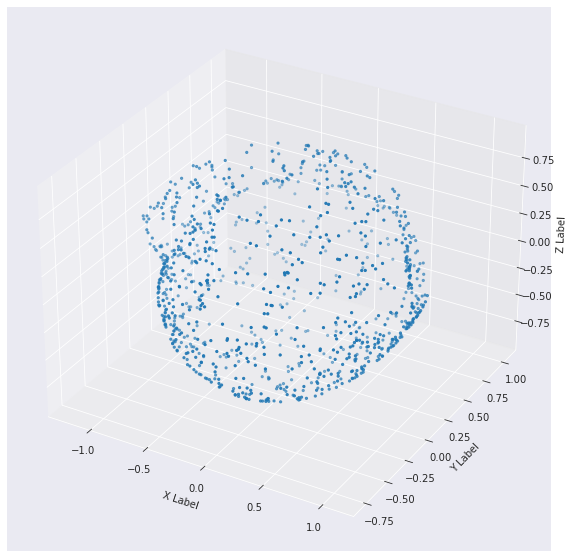

Training loss at step 1901: 3.4807
negative log-likelihood: 2.1503 	 MSE: 1.3305
Training loss at step 1902: 3.5051
negative log-likelihood: 2.1753 	 MSE: 1.3298
Training loss at step 1903: 3.4982
negative log-likelihood: 2.1632 	 MSE: 1.3350
Training loss at step 1904: 3.5056
negative log-likelihood: 2.1680 	 MSE: 1.3377
Training loss at step 1905: 3.5169
negative log-likelihood: 2.1848 	 MSE: 1.3321
Training loss at step 1906: 3.5096
negative log-likelihood: 2.1752 	 MSE: 1.3344
Training loss at step 1907: 3.5061
negative log-likelihood: 2.1693 	 MSE: 1.3368
Training loss at step 1908: 3.4872
negative log-likelihood: 2.1545 	 MSE: 1.3327
Training loss at step 1909: 3.4956
negative log-likelihood: 2.1632 	 MSE: 1.3324
Training loss at step 1910: 3.4979
negative log-likelihood: 2.1621 	 MSE: 1.3358
Training loss at step 1911: 3.4967
negative log-likelihood: 2.1618 	 MSE: 1.3349
Training loss at step 1912: 3.4905
negative log-likelihood: 2.1562 	 MSE: 1.3343
Training loss at step 1913: 

In [ ]:
flow, loss = train_model(flow, data, **params)

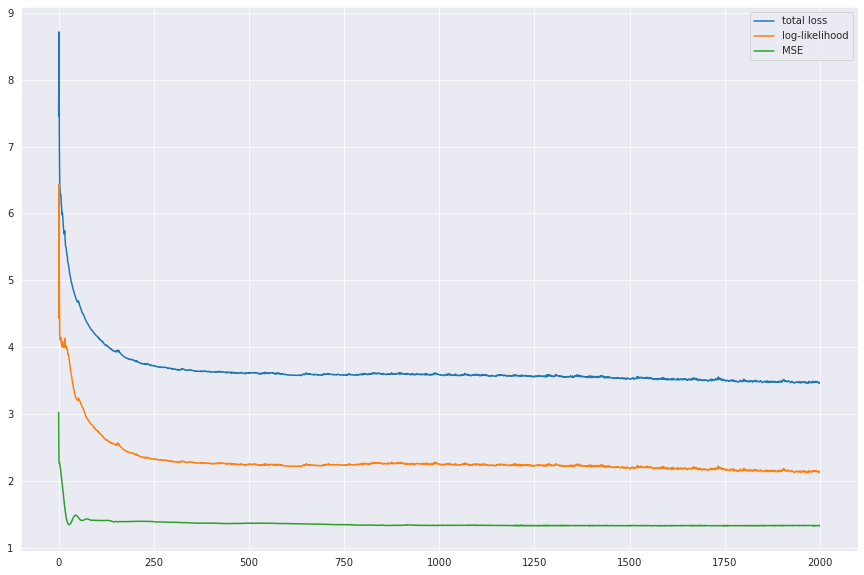

In [77]:
plt.figure(figsize=(15,10))
plt.plot(range(len(loss)), loss[:,0], label="total loss")
plt.plot(range(len(loss)), loss[:,1], label="log-likelihood")
plt.plot(range(len(loss)), loss[:,2], label="MSE")
plt.legend()
plt.show()

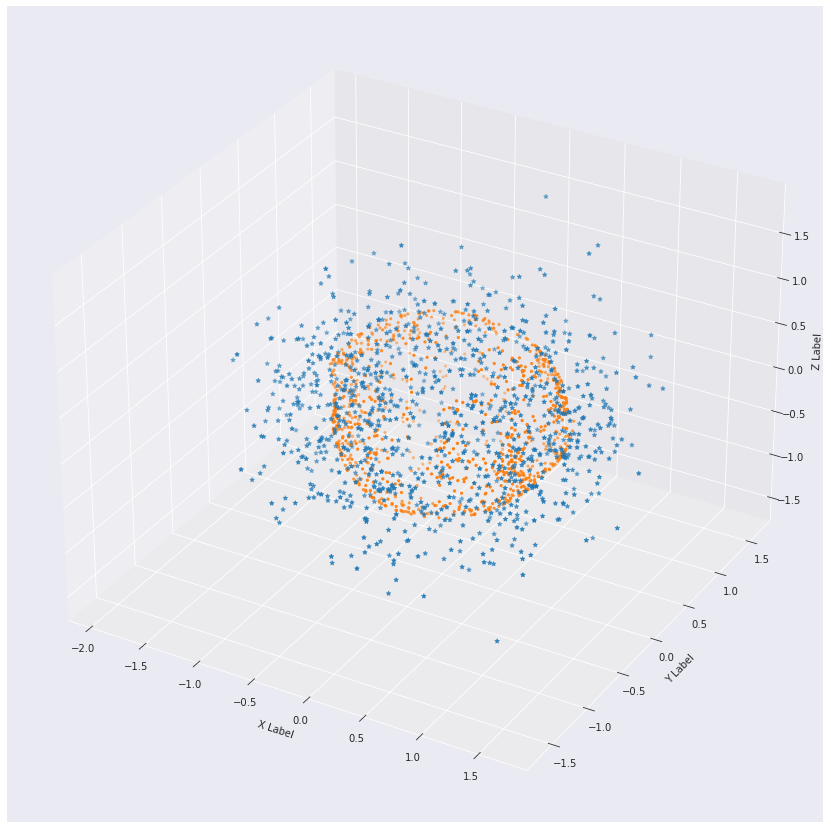

In [70]:
samples_cart, _ = flow.sample_and_log_prob(num_samples=1000)
samples_cart_np = samples_cart.detach().cpu().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_np[:,0], data_np[:,1], data_np[:,2], marker="*")
ax.scatter(samples_cart_np[:,0], samples_cart_np[:,1], samples_cart_np[:,2], marker=".")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

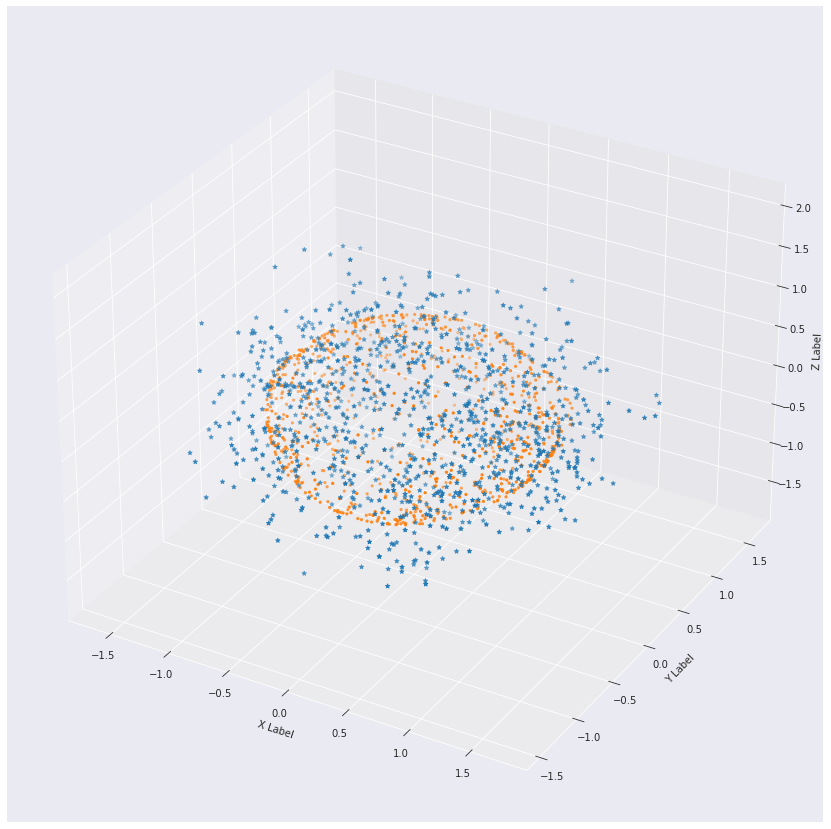

In [35]:
samples_sph, _ = flow._transform(data)
samples_cart_, _ = flow._transform.inverse(samples_sph)
samples_cart_np = samples_cart_.detach().cpu().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_np[:,0], data_np[:,1], data_np[:,2], marker="*")
ax.scatter(samples_cart_np[:,0], samples_cart_np[:,1], samples_cart_np[:,2], marker=".")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [53]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

In [71]:
n_samples = 10_000# 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples_reshaped = samples.reshape(-1, flow_dim)

100%|██████████| 20/20 [00:00<00:00, 87.82it/s]


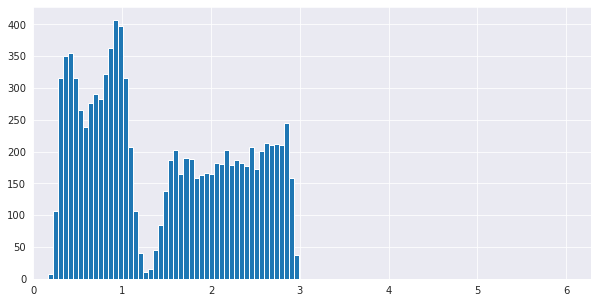

<Figure size 432x288 with 0 Axes>

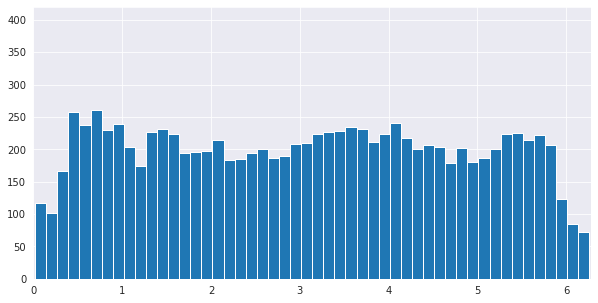

<Figure size 432x288 with 0 Axes>

In [72]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=400, linestyles='dashed', colors='b', edgecolor = "none")
    #plt.savefig(f"{dir_name}samples_p{q}_theta_flow_prior_angles_{i}.pdf", dpi=100)
    plt.xlim(0, 2*np.pi)
    plt.show()
    plt.clf()

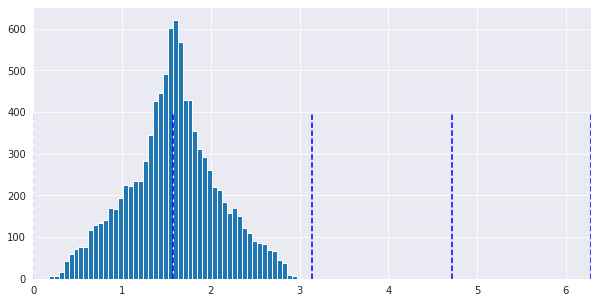

<Figure size 432x288 with 0 Axes>

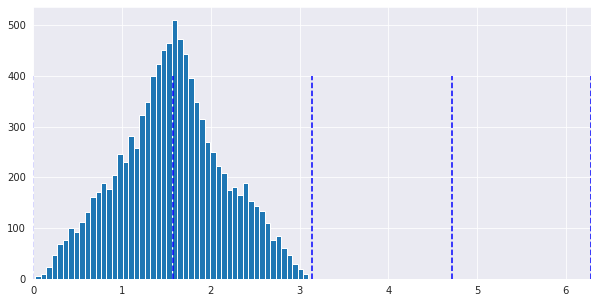

<Figure size 432x288 with 0 Axes>

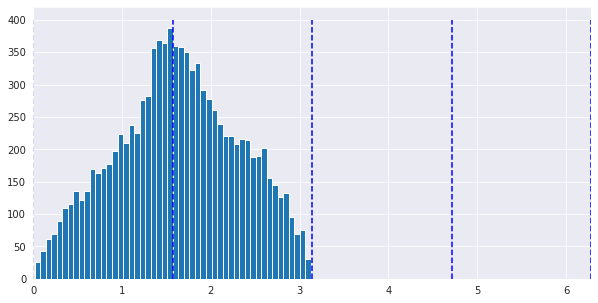

<Figure size 432x288 with 0 Axes>

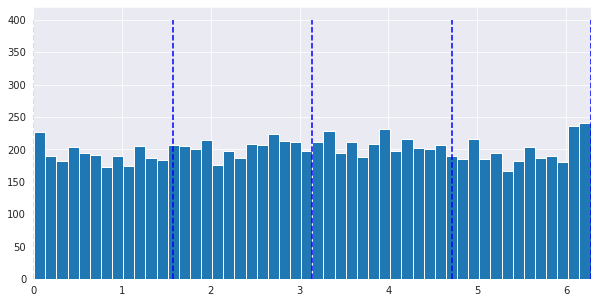

<Figure size 432x288 with 0 Axes>

In [105]:
samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    #n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=400, linestyles='dashed', colors='b', edgecolor = "none")
    #plt.savefig(f"{dir_name}samples_p{q}_theta_flow_prior_angles_{i}.pdf", dpi=100)
    plt.xlim(0, 2*np.pi)
    plt.show()
    plt.clf()

In [22]:
def lp_norm(arr, p):
    norm = np.sum(np.power(np.abs(arr), p), 1)
    norm = np.power(norm, 1/p).reshape(-1,1)
    return arr/norm

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [121]:
from rpy2.robjects.packages import importr
rpgnorm = importr('pgnorm')
q=1
n_samples = 50000
flow_dim = 10
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


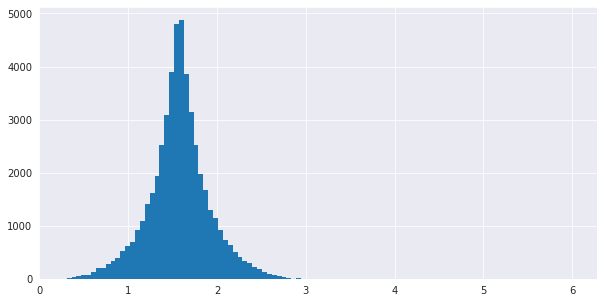

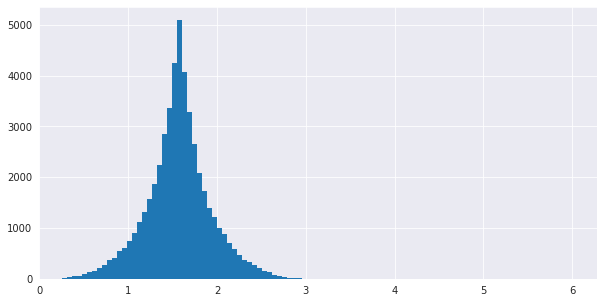

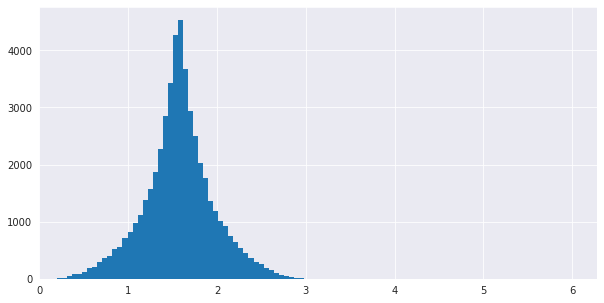

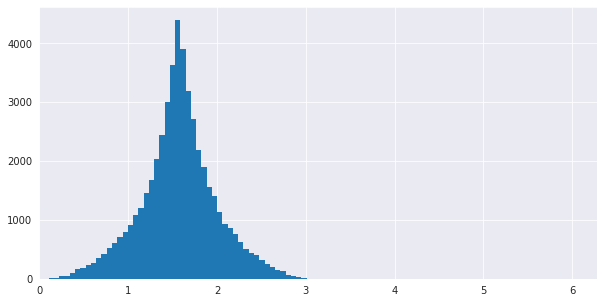

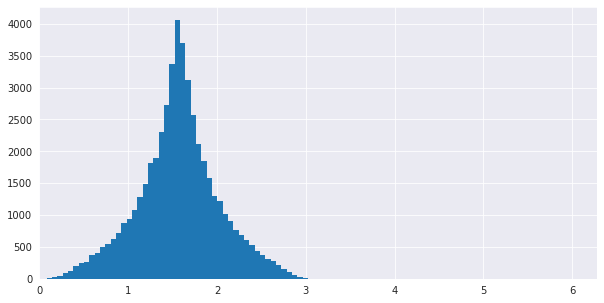

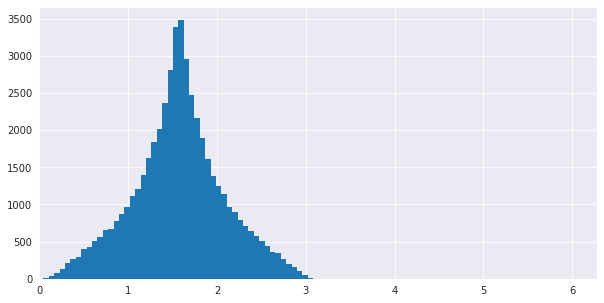

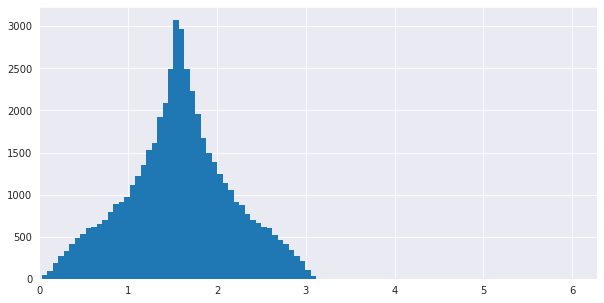

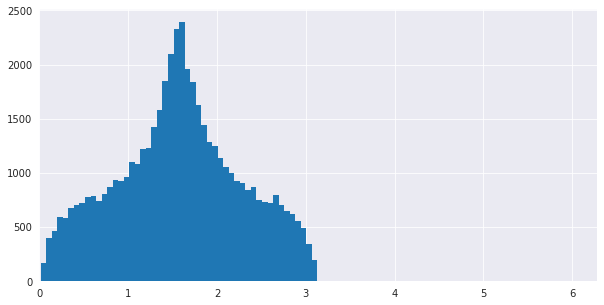

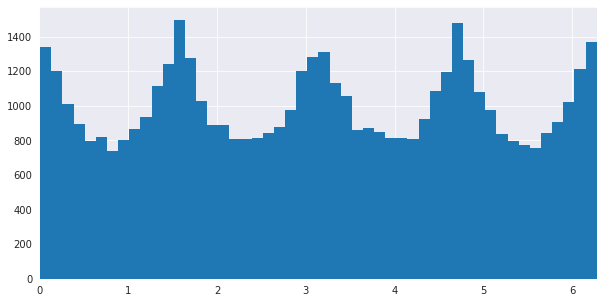

In [122]:
samples_spherical = cartesian_to_spherical_torch(torch.from_numpy(samples_norm)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    # n, bins, patches = plt.hist(samples_spherical[:,i], bins=200)
    plt.hist(samples_spherical[:,i], bins=50, edgecolor = "none")
    #plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
    plt.xlim(0,2*np.pi)
    plt.show()